In [39]:
import numpy as np
from glm_utils import *
import glm_model as gm
import tensorflow as tf

%load_ext autoreload
%autoreload 2

%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<font face = "Computer Modern", size = 3>

Generate 1000 points of poisson data, with a 30 element gaussian shaped filter, and a sigmoidal non-linearity with offset of 3 and scale of 5, and then fit it using TF. 

In [40]:
stim, weights, y = generate_poisson_data(T = 1000, n = 30, c = 3, scale = 5, filt_amp = 10)

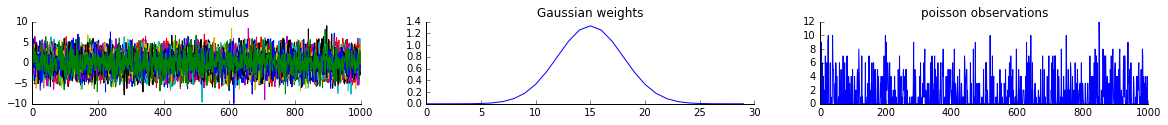

In [41]:
plt.figure(figsize = [20, 5])

ax = plt.subplot(331)
plt.plot(stim)
plt.title('Random stimulus')
simpleaxis(ax)

ax = plt.subplot(332)
plt.plot(weights)
plt.title('Gaussian weights')
simpleaxis(ax)

ax = plt.subplot(333)
plt.plot(y)
plt.title('poisson observations')
simpleaxis(ax)

In [42]:
weight_init = np.linalg.pinv(stim).dot(y)
pois_mod = gm.poisson_GLM(30, weight_init.reshape([30, 1]), max_iters=1000)

L, l = pois_mod.fit(stim, y, stim, y, batch_size = 1000, non_lin = tf.sigmoid)

0%                          100%
[******************************] | ETA: 00:00:00
Total time elapsed: 00:00:04


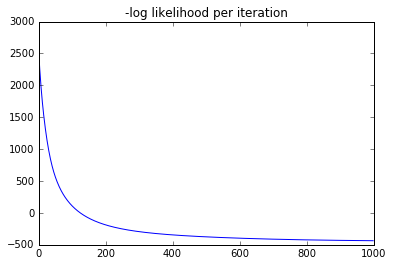

In [43]:
plt.plot(L)
plt.title('-log likelihood per iteration')

In [44]:
w_, o_, s_ = pois_mod.get_params()

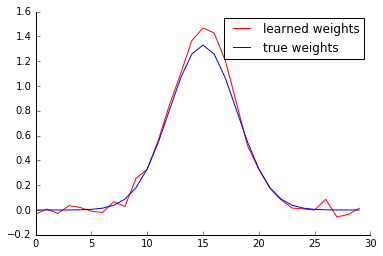

In [45]:
ax = plt.subplot(111)
plt.plot(w_, 'r', label = 'learned weights')
plt.plot(weights, 'b', label = 'true weights')
plt.legend()
simpleaxis(ax)

<font face = "Computer Modern", size = 3>



Now we do the same thing with generating data from a gaussian glm. 

In [46]:
stim, weights, y = generate_gaussian_data(T = 1000, n = 30, c = 3, scale = 5, filt_amp = 10)

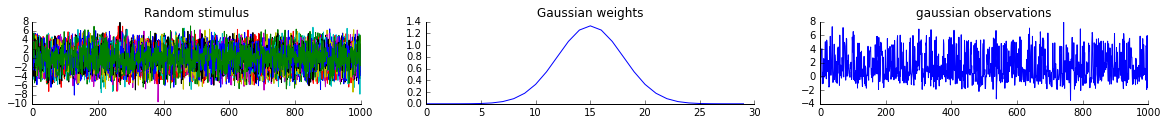

In [47]:
plt.figure(figsize = [20, 5])

ax = plt.subplot(331)
plt.plot(stim)
plt.title('Random stimulus')
simpleaxis(ax)

ax = plt.subplot(332)
plt.plot(weights)
plt.title('Gaussian weights')
simpleaxis(ax)

ax = plt.subplot(333)
plt.plot(y)
plt.title('gaussian observations')
simpleaxis(ax)

In [48]:
weight_init = np.linalg.pinv(stim).dot(y)
gaus_mod = gm.gaussian_GLM(30, weight_init.reshape([30, 1]), max_iters=500)

L, l = gaus_mod.fit(stim, y, stim, y, batch_size = 1000, non_lin = tf.sigmoid)

0%                          100%
[******************************] | ETA: 00:00:00
Total time elapsed: 00:00:02


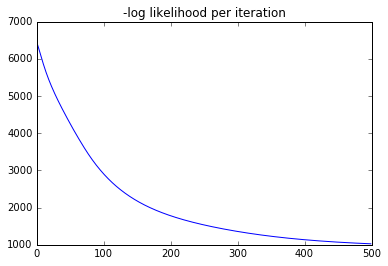

In [49]:
plt.plot(L)
plt.title('-log likelihood per iteration')

In [50]:
w_, o_, s_ = gaus_mod.get_params()

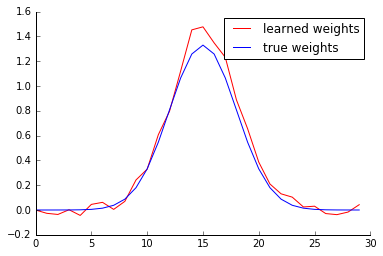

In [51]:
ax = plt.subplot(111)
plt.plot(w_, 'r', label = 'learned weights')
plt.plot(weights, 'b', label = 'true weights')
plt.legend()
simpleaxis(ax)

And finally for the exponential (gamma) GLM. 

In [52]:
stim, weights, y = generate_sig_data(T = 1000, n = 30, c = 3, scale = 5, filt_amp = 10)

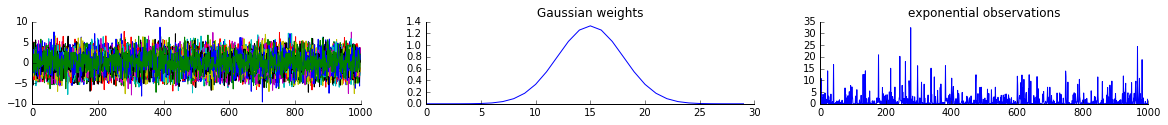

In [53]:
plt.figure(figsize = [20, 5])

ax = plt.subplot(331)
plt.plot(stim)
plt.title('Random stimulus')
simpleaxis(ax)

ax = plt.subplot(332)
plt.plot(weights)
plt.title('Gaussian weights')
simpleaxis(ax)

ax = plt.subplot(333)
plt.plot(y)
plt.title('exponential observations')
simpleaxis(ax)

In [54]:
weight_init = np.linalg.pinv(stim).dot(y)
exp_mod = gm.exponential_GLM(30, weight_init.reshape([30, 1]), max_iters=100)

L, l = exp_mod.fit(stim, y, stim, y, batch_size = 1000, non_lin = tf.sigmoid)

0%                          100%
[******************************] | ETA: 00:00:00
Total time elapsed: 00:00:00


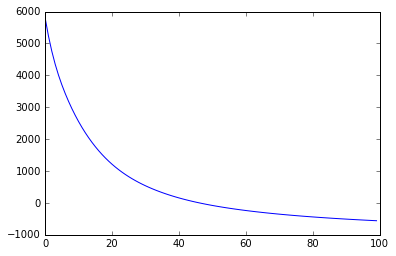

In [55]:
plt.plot(L)

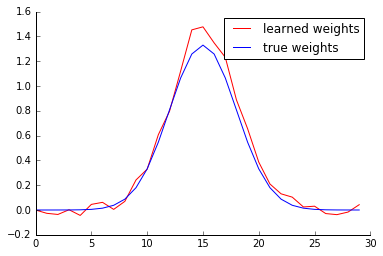

In [56]:
w_, o_, s_ = gaus_mod.get_params()

ax = plt.subplot(111)
plt.plot(w_, 'r', label = 'learned weights')
plt.plot(weights, 'b', label = 'true weights')
plt.legend()
simpleaxis(ax)